In [1]:
# import the required libraries

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import DenseNet121

## Loading Images from the Disk

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../datasets-4",
    seed=123, # this will ensure we get the same images each time
    shuffle=True, # images inside the batches will be shuffled
    image_size=(IMAGE_SIZE,IMAGE_SIZE), # every image will be of 128x128 dimension
    batch_size=BATCH_SIZE # There will be 64 images in each batch
)

Found 2814 files belonging to 4 classes.


2023-05-18 16:45:03.041269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 16:45:03.161851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 16:45:03.162148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-18 16:45:03.162989: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Splitting the Dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [4]:
total_batches = len(dataset)
train_size = int(0.80 * total_batches)
test_size = int(0.10 * total_batches)
val_size = total_batches - train_size - test_size

print(f"""
    Total Batches: {total_batches},
    Training Batches: {train_size},
    Testing Batches: {test_size},
    Validation Batches: {val_size}
""")

train_ds = dataset.take(train_size) # used for training data
test_ds = dataset.skip(train_size).take(test_size) # final evaluation will be done on this model
val_ds = dataset.skip(train_size + test_size).take(val_size) # used to tune the model


    Total Batches: 88,
    Training Batches: 70,
    Testing Batches: 8,
    Validation Batches: 10



## Cache, Shuffle, and Prefetch the Dataset

In [5]:
train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(2000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Image Augmentation

In [6]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Augmentation on Training Data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Designing and Training the Model

In [8]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(dataset.class_names)

# Load DenseNet model
base_model = DenseNet121(
    weights='imagenet', 
    include_top=False, 
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
)

# Freeze the layers in the base model
base_model.trainable = False

In [9]:
# Create the model by adding additional layers on top of the base model
inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [10]:
model.build(input_shape=input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                             

In [11]:
# compile the model
model.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer='Adam',
    metrics= ["accuracy"]
)

In [12]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=20
)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(
    filepath="finalproject_weights.h5", 
    verbose=1, 
    save_best_only=True
)

In [13]:
history = model.fit(
    train_ds, 
    epochs = 100,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    callbacks=[earlystopping, checkpointer]
)

Epoch 1/100


2023-05-18 16:45:25.641097: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 13 of 2000
2023-05-18 16:45:35.351175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 35 of 2000
2023-05-18 16:45:45.296247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 57 of 2000
2023-05-18 16:45:51.980083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-05-18 16:45:53.572002: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2023-05-18 16:45:54.917290: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


70/70 [==============================] - ETA: 0s - loss: 0.8318 - accuracy: 0.6754

2023-05-18 16:47:11.713235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 2000
2023-05-18 16:47:12.342581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 2000
2023-05-18 16:47:12.349037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 2000
2023-05-18 16:47:12.355636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4 of 2000
2023-05-18 16:47:12.392827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.



Epoch 1: val_loss improved from inf to 0.57097, saving model to finalproject_weights.h5
70/70 [==============================] - 129s 1s/step - loss: 0.8318 - accuracy: 0.6754 - val_loss: 0.5710 - val_accuracy: 0.7767
Epoch 2/100
70/70 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.8036
Epoch 2: val_loss improved from 0.57097 to 0.53568, saving model to finalproject_weights.h5
70/70 [==============================] - 32s 454ms/step - loss: 0.5006 - accuracy: 0.8036 - val_loss: 0.5357 - val_accuracy: 0.7799
Epoch 3/100
70/70 [==============================] - ETA: 0s - loss: 0.4462 - accuracy: 0.8232
Epoch 3: val_loss improved from 0.53568 to 0.52707, saving model to finalproject_weights.h5
70/70 [==============================] - 32s 453ms/step - loss: 0.4462 - accuracy: 0.8232 - val_loss: 0.5271 - val_accuracy: 0.7925
Epoch 4/100
70/70 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8612
Epoch 4: val_loss improved from 0.52707 to 0.432

## Model Evaluation

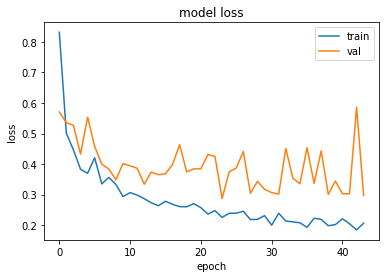

In [14]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

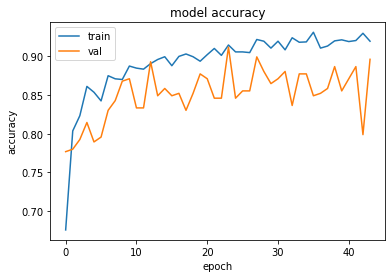

In [15]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("finalproject_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [17]:
# Load pretrained model (best saved one)
with open('finalproject_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
# load the model  
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('finalproject_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [18]:
scores = model.evaluate(test_ds)

2023-05-18 17:10:28.708311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 2000
2023-05-18 17:10:29.114274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 2000
2023-05-18 17:10:29.672667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 2000
2023-05-18 17:10:30.841669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6 of 2000
2023-05-18 17:10:32.390671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


8/8 [==============================] - 47s 188ms/step - loss: 0.2564 - accuracy: 0.9062


In [19]:
predict = []
y_test = np.array([])
for images, labels in test_ds:
    y_test = np.concatenate((y_test, labels.numpy()), axis=0).astype(int)
    predictions = model.predict(images)
    predict.extend(np.argmax(predictions, axis=1))
predict = np.asarray(predict)

In [20]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
print(f"Accuracy: {accuracy}")

Accuracy: 0.90625


<AxesSubplot:>

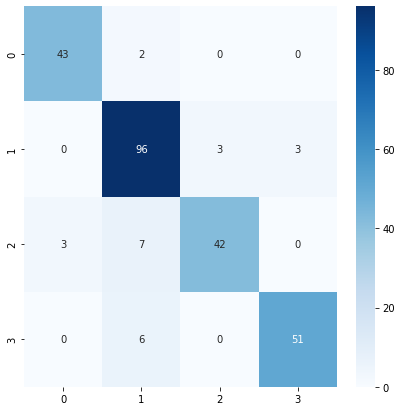

In [21]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, cmap='Blues')

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95        45
           1       0.86      0.94      0.90       102
           2       0.93      0.81      0.87        52
           3       0.94      0.89      0.92        57

    accuracy                           0.91       256
   macro avg       0.92      0.90      0.91       256
weighted avg       0.91      0.91      0.91       256

